# L46 Mini Project

## Imports and device setup

In [1]:
import time
from typing import Optional, Tuple, Literal
import json
import math
import types

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    PreTrainedTokenizerBase,
    PreTrainedModel,
)

from torch import nn
import torch.utils.checkpoint

from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    rotate_half,
    repeat_kv,
)

from transformers.cache_utils import Cache

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# change appropriately
device = "mps"

In [3]:
LLAMA_MODEL_PATH = "/Users/aszab/repos/models/Llama-3.2-1B"

In [4]:
GPT2_MODEL_PATH = "/Users/aszab/repos/models/gpt2"

## Preliminaries

### Chosen models

GPT2 and Llama3.2-1B.

TODO: 
- [ ] Write about them and their specifics. (PEs, attention, dimensions, num parameters)
- [ ] Show example generations.
- [ ] Add a note where I used part of the streaming_llm or transformers implementation

In [5]:
def load_model_tokenizer(
    model_path: str,
    output_attn: bool = False,
    attn_implementation: Optional[str] = None,
) -> tuple[PreTrainedModel, PreTrainedTokenizerBase]:
    # TODO add docstring
    model = AutoModelForCausalLM.from_pretrained(
        pretrained_model_name_or_path=model_path,
        output_attentions=output_attn,
        attn_implementation=attn_implementation,
    ).to(device)

    tokenizer = AutoTokenizer.from_pretrained(model_path)

    if model.config.pad_token_id is None:
        model.config.pad_token_id = model.config.eos_token_id

    return model, tokenizer

In [68]:
llama3_model, llama3_tokenizer = load_model_tokenizer(
    LLAMA_MODEL_PATH, attn_implementation="eager"
)

In [69]:
gpt2_model, gpt2_tokenizer = load_model_tokenizer(
    GPT2_MODEL_PATH, attn_implementation="eager"
)

In [6]:
def generate_text(
    prompt: str,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerBase,
    num_tokens: int = 10,
) -> list[str]:
    # TODO add docstring
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generations = []

    for _ in range(num_tokens):
        with torch.no_grad():
            outputs = model(
                **inputs,
            )
        pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
        inputs["input_ids"] = torch.cat([inputs["input_ids"], pred_token_idx], dim=-1)
        inputs["attention_mask"] = torch.cat(
            [inputs["attention_mask"], torch.ones_like(pred_token_idx)], dim=-1
        )
        pred_token = tokenizer.decode(pred_token_idx[0])
        generations.append(pred_token)

    return generations

GPT-2 example generation

In [ ]:
start_time = time.time()
prompt = "Hello, my dog is cute and"
print("".join(generate_text(prompt, gpt2_model, gpt2_tokenizer, 100)))
print(f"\n---\n{time.time() - start_time:.2f} seconds")

 I love him. I'm not sure if he's a good dog, but I'm sure he's a good dog. I'm not sure if he's a good dog, but I'm sure he's a good dog.

I'm

---
1.89 seconds


LLama3.2-1B generation

In [35]:
start_time = time.time()
prompt = "Hello, my dog is cute and"
print("".join(generate_text(prompt, llama3_model, llama3_tokenizer, 100)))
print(f"\n---\n{time.time() - start_time:.2f} seconds")

 playful, but he is very aggressive and he bites me when I try to pet him. I have tried to train him, but he is very stubborn and he doesn’t listen to me. I have tried to use a leash, but he still bites

---
8.06 seconds


#TODO: Explain why attention scales quadratically. (Maybe show one of the graphs from the website? https://medium.com/@joaolages/kv-caching-explained-276520203249)

Instead of calculating the attention components at each decoding step, we can reuse the already computed keys and values by caching them and using in the next decoding step.

Conveniently, the default implementation of both GPT2 and Llama3.2 from the `transformers` library returns the computed keys and values during a generation in the `outputs.past_key_values` object of type `tuple[tuple[torch.Tensor[batch_size, attn_head_num, seq_num, attn_head_dim]]]`, where the first tuple is of the dimension of the number of decoder layers, while the second is 2-dimensional with the first element being keys and the latter being values.


In [36]:
def generate_text_kv_caching(
    prompt: str,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerBase,
    num_tokens: int = 10,
    kv_cache_size: int = -1,
) -> list[str]:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generations = []

    # First compute all the KV caches for the prompt
    with torch.no_grad():
        outputs = model(
            **inputs,
        )
    past_key_values = outputs.past_key_values
    generations.append(
        tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])
    )

    # Now generate the rest of the tokens one by one
    for _ in range(num_tokens):
        pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
        with torch.no_grad():
            outputs = model(
                pred_token_idx,
                labels=None,
                past_key_values=past_key_values,
                use_cache=True,
            )
        past_key_values = outputs.past_key_values
        if kv_cache_size != -1 and past_key_values[0][0].shape[2] >= kv_cache_size:
            past_key_values = [
                [param[:, :, -kv_cache_size:, :] for param in layer]
                for layer in past_key_values
            ]

        generations.append(
            tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])
        )
    return generations

In [ ]:
start_time = time.time()
prompt = "Hello, my dog is cute and"
print(
    "".join(
        generate_text_kv_caching(
            prompt,
            gpt2_model,
            gpt2_tokenizer,
            100,
        )
    )
)
print(f"\n---\n{time.time() - start_time:.2f} seconds")

In [37]:
start_time = time.time()
prompt = "Hello, my dog is cute and"
print(
    "".join(
        generate_text_kv_caching(
            prompt,
            llama3_model,
            llama3_tokenizer,
            100,
        )
    )
)
print(f"\n---\n{time.time() - start_time:.2f} seconds")

 playful, but he is very aggressive and he bites me when I try to pet him. I have tried to train him, but he is very stubborn and he doesn’t listen to me. I have tried to use a leash, but he still bites me

---
2.59 seconds


When the cache capacity is exceeded, some of the tokens need to be evicted. The default cache implementation, also known as *window attention* uses the least recently used (LRU) cache eviction policy. Let's set the `kv_cache_size`=20 tokens and observe the results. 

In [ ]:
start_time = time.time()
prompt = "Hello, my dog is cute and"
print(
    "".join(
        generate_text_kv_caching(
            prompt,
            llama3_model,
            llama3_tokenizer,
            50,
            kv_cache_size=20,
        )
    )
)
print(f"\n---\n{time.time() - start_time:.2f} seconds")

 playful, but he is very aggressive and he bites me when I try, he dog bites me bites me aggressive aggressive aggressive aggressive aggressive aggressive aggressive bites bites bites bites bites bites bites biteseseseseseseseseseseseseseseses

---
2.21 seconds


As expected from the original paper by Xiao et al., the model's ability to generate text drastically vanishes. The authors argue that it is caused by ejecting the position from the kv cache, which in fact serves as an attention sink -- a place to "dump" attention score resulting from its softmax formulation. 

#TODO Describe more why this happens

They propose a novel method, called sink attention, which modifies the cache eviction policy by always keeping the first *n* tokens.

#TODO add attention diagrams.

## Experiment 1

The first experiment serves as a way to replicate and deepen the results obtained by Xiao et al., using a new generation model -- Llama3.2-1B. 

Following Xiao et al., we implement 4 types of attention computations:
- Dense attention
- Window attention
- Sliding window with recomputation
- Sink attention

We compare the 4 implementation using a commonly used test split of the `wikitext-2` dataset to evaluate model perplexity, generation time and kv-cache memory usage of GPT-2 and LLama3.2.

### Implementation of sink attention forward pass 

However, implementing sink attention additionally involves shifting the positional encodings, which are added to the keys and values for attention computation. This allows the model to decode sequences even past the maximum sequence length on which it was trained.

Most modern models use Rotary Positional Embeddings (RoPE), relative positional encodings or ALiBi (Attention with Linear Biases), which directly affect how attention is computed. Llama3.2 uses RoPEs, which are added to the keys and queries before they are stored in the kv cache. Since sink attention involves shifting positions of stored keys and values, it is necessary to reimplement the attention pass for the model. To do so, I will modify the [original `transformers` implementation of the *eager attention* forward pass](https://github.com/huggingface/transformers/blob/241c04d36867259cdf11dbb4e9d9a60f9cb65ebc/src/transformers/models/llama/modeling_llama.py#L290-L358) and replace all its calls with the modified version.

#TODO explain that the positional encodings need to be recomputed each time the attention pass is performed but some computation can be saved if implemented from scratch.

In [15]:
def apply_rotary_pos_emb_x(x, cos, sin, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    x_embed = (x * cos) + (rotate_half(x) * sin)
    return x_embed


def llama_modified_attention_forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    past_key_value: Optional[Cache] = None,
    output_attentions: bool = False,
    position_embeddings: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
    **kwargs,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    bsz, q_len, _ = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

    # use -1 to infer num_heads and num_key_value_heads as they may vary if tensor parallel is used
    query_states = query_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)

    # Figure out the length of the key value sequence given current and cached key value states
    kv_seq_len = key_states.shape[-2]
    if past_key_value is not None and len(past_key_value) > self.layer_idx:
        kv_seq_len += past_key_value[self.layer_idx][0].shape[-2]

    # If we have a cache, we can use it to avoid recomputing the key value states.
    # NOTE: Keys are stored without positional encodings added.
    if past_key_value is not None:
        key_states, value_states = past_key_value.update(
            key_states,
            value_states,
            self.layer_idx,
        )

    # Recompute rotary_emb for the entire sequence. In theory this could be done once when the model is instantiated.
    cos, sin = self.rotary_emb(
        value_states,
        position_ids=torch.arange(kv_seq_len, device=value_states.device).unsqueeze(0),
    )

    # Compute keys and queries with rotary embeddings separately given they may have different lengths due to caching.
    key_states = apply_rotary_pos_emb_x(key_states, cos, sin)
    query_states = apply_rotary_pos_emb_x(
        query_states, cos[:, -q_len:, :], sin[:, -q_len:, :]
    )

    # Continue with the original transformers Llama implementation
    key_states = repeat_kv(
        key_states,
        self.num_key_value_groups,
    )
    value_states = repeat_kv(
        value_states,
        self.num_key_value_groups,
    )
    attn_weights = torch.matmul(
        query_states,
        key_states.transpose(2, 3),
    ) / math.sqrt(self.head_dim)

    if attention_mask is not None:  # no matter the length, we just slice it
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    # upcast attention to fp32
    attn_weights = nn.functional.softmax(
        attn_weights,
        dim=-1,
        dtype=torch.float32,
    ).to(query_states.dtype)
    attn_weights = nn.functional.dropout(
        attn_weights, p=self.attention_dropout, training=self.training
    )
    attn_output = torch.matmul(attn_weights, value_states)

    if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
        raise ValueError(
            f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
            f" {attn_output.size()}"
        )

    attn_output = attn_output.transpose(1, 2).contiguous()

    attn_output = attn_output.reshape(bsz, q_len, -1)

    attn_output = self.o_proj(attn_output)

    if not output_attentions:
        attn_weights = None

    return attn_output, attn_weights, past_key_value


# Replace all default llama attention modules with the new implementation above.
def enable_llama_pos_shift_attention(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            enable_llama_pos_shift_attention(
                module,
            )

        if isinstance(module, LlamaAttention):
            model._modules[name].forward = types.MethodType(
                llama_modified_attention_forward, model._modules[name]
            )

#### Verify the correctness of the implementation

Here we verify the correctness of the attention forward pass implementation.

#TODO explain how we are verifying the correctness 

In [6]:
def load_data():
    data_wikitext = load_dataset(
        "wikitext", "wikitext-2-raw-v1", split="test", cache_dir="~/repos/datasets"
    )
    data_wikitext = "\n\n".join(
        list(filter(lambda x: len(x) > 0, data_wikitext["text"]))
    )

    return data_wikitext

In [47]:
data_wikitext = load_data()

encodings = llama3_tokenizer(data_wikitext, return_tensors="pt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


In [44]:
llama3_model, llama3_tokenizer = load_model_tokenizer(
    LLAMA_MODEL_PATH, attn_implementation="eager"
)

In [45]:
enable_llama_pos_shift_attention(llama3_model)

In [48]:
reference_llama3_model, _ = load_model_tokenizer(
    LLAMA_MODEL_PATH, attn_implementation="eager"
)

#### Qualitative evaluation on a sample text

In [51]:
prompt = "Hello, my dog is cute and"
num_tokens = 17
generation = generate_text_kv_caching(
    prompt,
    llama3_model,
    llama3_tokenizer,
    num_tokens=num_tokens,
)
reference_generation = generate_text_kv_caching(
    prompt,
    reference_llama3_model,
    llama3_tokenizer,
    num_tokens=num_tokens,
)

print(prompt + "...\n")
print("modified model | reference model")
for gen, ref_gen in zip(generation, reference_generation):
    print(gen + (len("modified model") - len(gen)) * " ", ref_gen, sep=" |")

Hello, my dog is cute and...

modified model | reference model
 playful       | playful
,              |,
 but           | but
 he            | he
 is            | is
 very          | very
 aggressive    | aggressive
 and           | and
 he            | he
 bites         | bites
 me            | me
 when          | when
 I             | I
 try           | try
 to            | to
 pet           | pet
 him           | him
.              |.


#### Test logits given a longer sequence

In [52]:
print(llama3_tokenizer.decode(encodings.input_ids[:, :512][0]))

<|begin_of_text|> = Robert Boulter = 


 Robert Boulter is an English film, television and theatre actor. He had a guest @-@ starring role on the television series The Bill in 2000. This was followed by a starring role in the play Herons written by Simon Stephens, which was performed in 2001 at the Royal Court Theatre. He had a guest role in the television series Judge John Deed in 2002. In 2004 Boulter landed a role as " Craig " in the episode " Teddy's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi. He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur, which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London. He was directed by John Tiffany and starred alongside Ben Whishaw, Shane Zaza, Harry Kent, Fraser Ayres, Sophie Stanton and Dominic Hall. 


 In 2006, Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill. He appeared on a 20

In [56]:
with torch.no_grad():
    outputs = llama3_model(
        encodings.input_ids[:, :512].to(device),
    )
    outputs_final = llama3_model(
        encodings.input_ids[:, :512].to(device),
        past_key_values=outputs.past_key_values,
    )

    reference_outputs = reference_llama3_model(
        encodings.input_ids[:, :512].to(device),
    )
    reference_outputs_final = reference_llama3_model(
        encodings.input_ids[:, :512].to(device),
        past_key_values=reference_outputs.past_key_values,
    )

In [57]:
assert torch.equal(outputs.logits, reference_outputs.logits)
assert torch.equal(outputs_final.logits, reference_outputs_final.logits)

#### Test caching across multiple generations

In [ ]:
past_key_values = None
reference_past_key_values = None

for idx in tqdm(range(1024)):
    tokens = encodings.input_ids[:, idx : idx + 1].to(device)
    with torch.no_grad():
        outputs = llama3_model(
            tokens,
            past_key_values=past_key_values,
        )
        past_key_values = outputs.past_key_values

        reference_outputs = reference_llama3_model(
            tokens,
            past_key_values=reference_past_key_values,
        )
        reference_past_key_values = reference_outputs.past_key_values

    assert torch.equal(outputs.logits, reference_outputs.logits)

    # clean gpu cache on apple silicon
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

### Implementation of Dense Attention, Window Attention, Sliding Window with Recomputation, Sink Attention

In [7]:
# Cache eviction policy for sink attention. If sink_attn_tks is set to 0, the policy becomes lru (least recently used).
def cache_eviction_sink(
    kv_cache, kv_cache_size: int, sink_attn_tks: int
) -> list[list[torch.Tensor]]:
    # TODO add docstring
    return [
        [
            torch.cat(
                [
                    param[:, :, 0:sink_attn_tks, :],
                    param[:, :, -(kv_cache_size - sink_attn_tks) :, :],
                ],
                2,
            )
            for param in head
        ]
        for head in kv_cache
    ]

- For dense attention set `kv_cache_size=-1`, `sink_attn_tks=0`.
- For window attention set `kv_cache_size` to desired max cache length value and `sink_attn_tks=0`.
- For sliding window with recomputation set `recompute=True` and set `kv_cache_size` to desired max window value.
- For sink attention set both `kv_cache_size` and `sink_attn_tks` to desired values.

`chunk_len` specifies the maximum length of an evaluation sequence. E.g. `chunk_len=5` computes over `A B C D E` F G H I J K

`num_passes` specifies the max number of PPL computations over a sequence of length `chunk_len`. 

`shift_len` specifies the number of tokens the main sequence is shifted by to compute perplexity for the next pass.

E.g. `num_passes=3, chunk_len=5, shift_len=2` computes over:
- `A B C D E` F G H I J K ...
- A B `C D E F G` H I J K ...
- A B C D `E F G H I` J K ...

In [194]:
def benchmark_attention_implementation(
    model,
    encodings,
    num_passes,
    chunk_len,
    shift_len,
    kv_cache_size,
    sink_attn_tks,
    recomputation: bool = False,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    max_seq_len = encodings.input_ids.size(1)

    assert num_passes * chunk_len <= max_seq_len
    seq_len = shift_len * num_passes
    print(f"chunk_len: {chunk_len}")

    global_nlls = []
    global_generation_time = []
    global_past_key_values_size = []
    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

    # iterate through the sequence in chunks
    for begin_idx in range(0, seq_len, shift_len):
        end_idx = min(begin_idx + chunk_len, max_seq_len)
        print(f"{begin_idx=}, {end_idx=}")

        pbar = tqdm(range(begin_idx, end_idx))

        past_key_values = None

        nlls = []
        generation_time = []
        past_key_values_size = []

        # iterate through the chunk
        for idx in pbar:
            if recomputation:
                # Sliding window with recomputation:
                # Take a cache-sized window of tokens and process it through the model
                input_ids = encodings.input_ids[
                    :, max(0, idx - kv_cache_size) : idx + 1
                ].to(device)
                with torch.no_grad():

                    start_time = time.time()
                    outputs = model(input_ids)

                    generation_time.append(time.time() - start_time)
            else:
                # Dense/Window/Sink attention:
                # process tokens one by one
                input_ids = encodings.input_ids[:, idx : idx + 1].to(model.device)
                with torch.no_grad():

                    start_time = time.time()
                    outputs = model(
                        input_ids,
                        past_key_values=past_key_values,
                        use_cache=True,
                    )

                    generation_time.append(time.time() - start_time)

            # compute the negative log likelihood
            logits = outputs.logits[:, -1, :]
            label = encodings.input_ids[:, idx + 1 : idx + 2].to(logits.device).view(-1)
            neg_log_likelihood = loss_fn(logits, label)

            if not recomputation:
                # update the key value cache
                past_key_values = outputs.past_key_values

                # cache eviction -- implement window/sink attention
                if (
                    kv_cache_size != -1
                    and past_key_values[0][0].shape[2] >= kv_cache_size
                ):
                    past_key_values = cache_eviction_sink(
                        past_key_values, kv_cache_size, sink_attn_tks
                    )

                # memory measurements
                past_key_values_size.append(
                    sum(
                        sum([p_i.numel() * p_i.element_size() for p_i in p])
                        for p in past_key_values
                    )
                )

            # clean apple mps cache (for some reason it does not flush automatically)
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

            # aggregate nlls within the chunk
            nlls.append(neg_log_likelihood)
            pbar.set_description(
                f"nll: {neg_log_likelihood.item():.2f}, ppl: {torch.exp(neg_log_likelihood).item():.2f}"
            )
        # aggregate results across chunks
        global_nlls.append(nlls)
        global_generation_time.append(generation_time)
        global_past_key_values_size.append(past_key_values_size)

    # average results across chunks
    global_nlls = torch.tensor(global_nlls).mean(dim=0)
    global_generation_times = torch.tensor(global_generation_time).mean(dim=0)
    global_past_key_values_size = torch.tensor(
        global_past_key_values_size, dtype=torch.float64
    ).mean(dim=0)

    return global_nlls, global_generation_times, global_past_key_values_size

#### Utility for scheduling experiments with attention 

In [195]:
def run_attention_experiment(
    data,
    config,
):
    # TODO add docstring

    print(
        f"Running the following global configuration:{config['name'], config['model'], config['num_passes'], config['chunk_len'], config.get('shift_len', 1)}"
    )
    for run in config["runs"]:
        print(f"Running the following run configuration:{run}")
        # load model and tokenize data with the corresponding tokenizer
        model, tokenizer = load_model_tokenizer(config["model"])
        encodings = tokenizer(data, return_tensors="pt")

        if run["attn_impl"] == "sink_attn":
            enable_llama_pos_shift_attention(model)

        if run.get("remove_bos_token", False):
            encodings.input_ids = encodings.input_ids[:, 1:]
            encodings.attention_mask = torch.ones_like(encodings.input_ids)

        nlls, generation_times, kv_sizes = benchmark_attention_implementation(
            model,
            encodings,
            config["num_passes"],
            config["chunk_len"],
            config.get("shift_len", 1),
            run.get("kv_cache_size", -1),
            run.get("sink_attn_tks", 0),
            recomputation=run.get("recompute", False),
        )
        run["results"] = {
            "nlls": nlls.tolist(),
            "generation_times": generation_times.tolist(),
            "kv_sizes": kv_sizes.tolist(),
        }

        with open(f"./experiment_results/results_{config['name']}.json", "w") as f:
            json.dump(config, f)

    return config

#### Function for summarising numerical results

In [196]:
def show_statistics(
    results, nll_probing_indices: list[int] = [10, 256, 512, 513, 768, 1024, 1536]
) -> None:
    # TODO add docstring
    data = []
    for run in results["runs"]:
        nlls = torch.tensor(run["results"]["nlls"])
        generation_times = torch.tensor(run["results"]["generation_times"])
        kv_sizes = torch.tensor(run["results"]["kv_sizes"])

        row = {
            "Name": run["name"],
            "Generation Time (mean ±std)": f"{generation_times.mean().item():.2f} ±{generation_times.std().item():.2f}",
            "Max Memory Usage [MB]": kv_sizes.max().item() // 1024**2,
            "PPL (mean ±std)": f"{torch.exp(nlls.mean()).item():.2f} ±{torch.exp(nlls.std()).item():.2f}",
        }

        for idx in nll_probing_indices:
            if idx < len(nlls):
                row[f"PPL @ {idx}"] = torch.exp(nlls[: idx + 1].mean()).item()
            else:
                row[f"PPL @ {idx}"] = None

        data.append(row)

    df = pd.DataFrame(data).round(4).set_index("Name").T
    print(df.to_string())

#### Functions for plotting the results

In [197]:
def show_nlls(
    results,
    kv_size_line: int = 0,
    context_length_line: int = 0,
):
    assert len(results["runs"]) > 0
    n_rows = len(results["runs"]) + 1

    fig, ax = plt.subplots(n_rows, 1, figsize=(14, 16))

    if kv_size_line > 0:
        for ax_id in range(n_rows):
            ax[ax_id].axvline(
                x=kv_size_line,
                color="green",
                linestyle="--",
                alpha=1,
                label="KV Cache Size",
            )
    if context_length_line > 0:
        for ax_id in range(n_rows):
            ax[ax_id].axvline(
                x=context_length_line,
                color="red",
                linestyle="--",
                alpha=1,
                label="Context Length",
            )

    colors = []
    for i, run in enumerate(results["runs"]):
        nlls = run["results"]["nlls"]

        a = ax[0].plot(
            range(len(nlls)),
            [torch.Tensor(nlls[: i + 1]).mean() for i in range(len(nlls))],
            ls=["-", "--", ":", "-."][i % 4],
            label=run.get("name", run["attn_impl"]),
        )
        colors.append(a[0].get_color())

    for idx, run in enumerate(results["runs"]):
        nlls = run["results"]["nlls"]
        ax[idx + 1].plot(
            range(len(nlls)),
            [(nlls[i]) for i in range(len(nlls))],
            "o",
            color=colors[idx],
            # linewidth=0.1,
            markersize=1,
            label=run.get("name", run["attn_impl"]),
        )

    ax[0].set_ylabel("Log PPL")

    for ax_id in range(n_rows):
        if ax_id > 0:
            ax[ax_id].set_ylabel("NLL (per token)")
            ax[ax_id].set_title(
                results["runs"][ax_id - 1].get(
                    "name", results["runs"][ax_id - 1]["attn_impl"]
                )
            )
        ax[ax_id].set_xlabel("Input size in tokens")
        ax[ax_id].grid(alpha=0.6, zorder=1)
        ax[ax_id].legend()
    plt.suptitle(f"PPL and NLL per token for experiment {results['name']}")
    fig.tight_layout()

In [198]:
def show_generation_times(results, y_upper_limit: int = 1):
    for run in results["runs"]:
        generation_times = run["results"]["generation_times"]
        plt.plot(
            range(len(generation_times)),
            generation_times,
            linewidth=0.5,
            alpha=0.8,
            label=run.get("name", run["attn_impl"]),
        )
    # plt.yscale("log")
    plt.title(f"Generation times for experiment {results['name']}")
    plt.xlabel("Input size in tokens")
    plt.ylabel("Time in seconds")
    plt.ylim(0, y_upper_limit)

    plt.legend()
    plt.grid(alpha=0.6, zorder=1)

In [199]:
def show_memory_usage(results):
    for i, run in enumerate(results["runs"]):
        past_key_values_size = run["results"]["kv_sizes"]

        # skip the sliding window with recomputation, since it does not use any cache
        if run["attn_impl"] == "sliding_window_w_recomputation_attn":
            plt.axhline(
                0,
                label=run.get("name", run["attn_impl"]),
                ls="--",
                color="grey",
                alpha=0.8,
            )
            continue
        plt.plot(
            range(len(past_key_values_size)),
            past_key_values_size,
            ls=["-", "--", ":", "-."][i % 4],
            label=run.get("name", run["attn_impl"]),
        )
    # plt.yscale("log")
    plt.title(f"KV-cache memory usage for experiment {results['name']}")
    plt.xlabel("Input size in tokens")
    plt.ylabel("Memory size in Bytes")

    plt.legend()
    plt.grid(alpha=0.6, zorder=1)

### And finally, the Experiment 1

First, we will use the Llama3.2 model and implement all 4 types of attention caching methods. We use a single sequence of 2048 tokens. For window, sliding window with recomputation and sink attention we use a kv cache of 512 tokens. For sink attention we dedicate 4 initial tokens to work as sinks.

We present the experiment configuration in the dictionary format below. 

In [16]:
experiment_1a_config = {
    "name": "experiment_1a",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA_MODEL_PATH,
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
    ],
}

#TODO Actually run this

In [17]:
results_1a = run_attention_experiment(load_data(), experiment_1a_config)

Running the following global configuration:('/Users/aszab/repos/models/Llama-3.2-1B', 1, 2048, 1)
Running the following run configuration:{'attn_impl': 'dense_attn', 'kv_cache_size': -1, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 1.76, ppl: 5.83: 100%|██████████| 2047/2047 [02:09<00:00, 15.79it/s]       


Running the following run configuration:{'attn_impl': 'window_attn', 'kv_cache_size': 512, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 11.29, ppl: 80079.44: 100%|██████████| 2047/2047 [01:44<00:00, 19.60it/s]   


Running the following run configuration:{'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 4}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 1.75, ppl: 5.74: 100%|██████████| 2047/2047 [02:31<00:00, 13.53it/s]       


Running the following run configuration:{'attn_impl': 'sliding_window_w_recomputation_attn', 'kv_cache_size': 512, 'recompute': True}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 1.95, ppl: 7.03: 100%|██████████| 2047/2047 [20:37<00:00,  1.65it/s]        


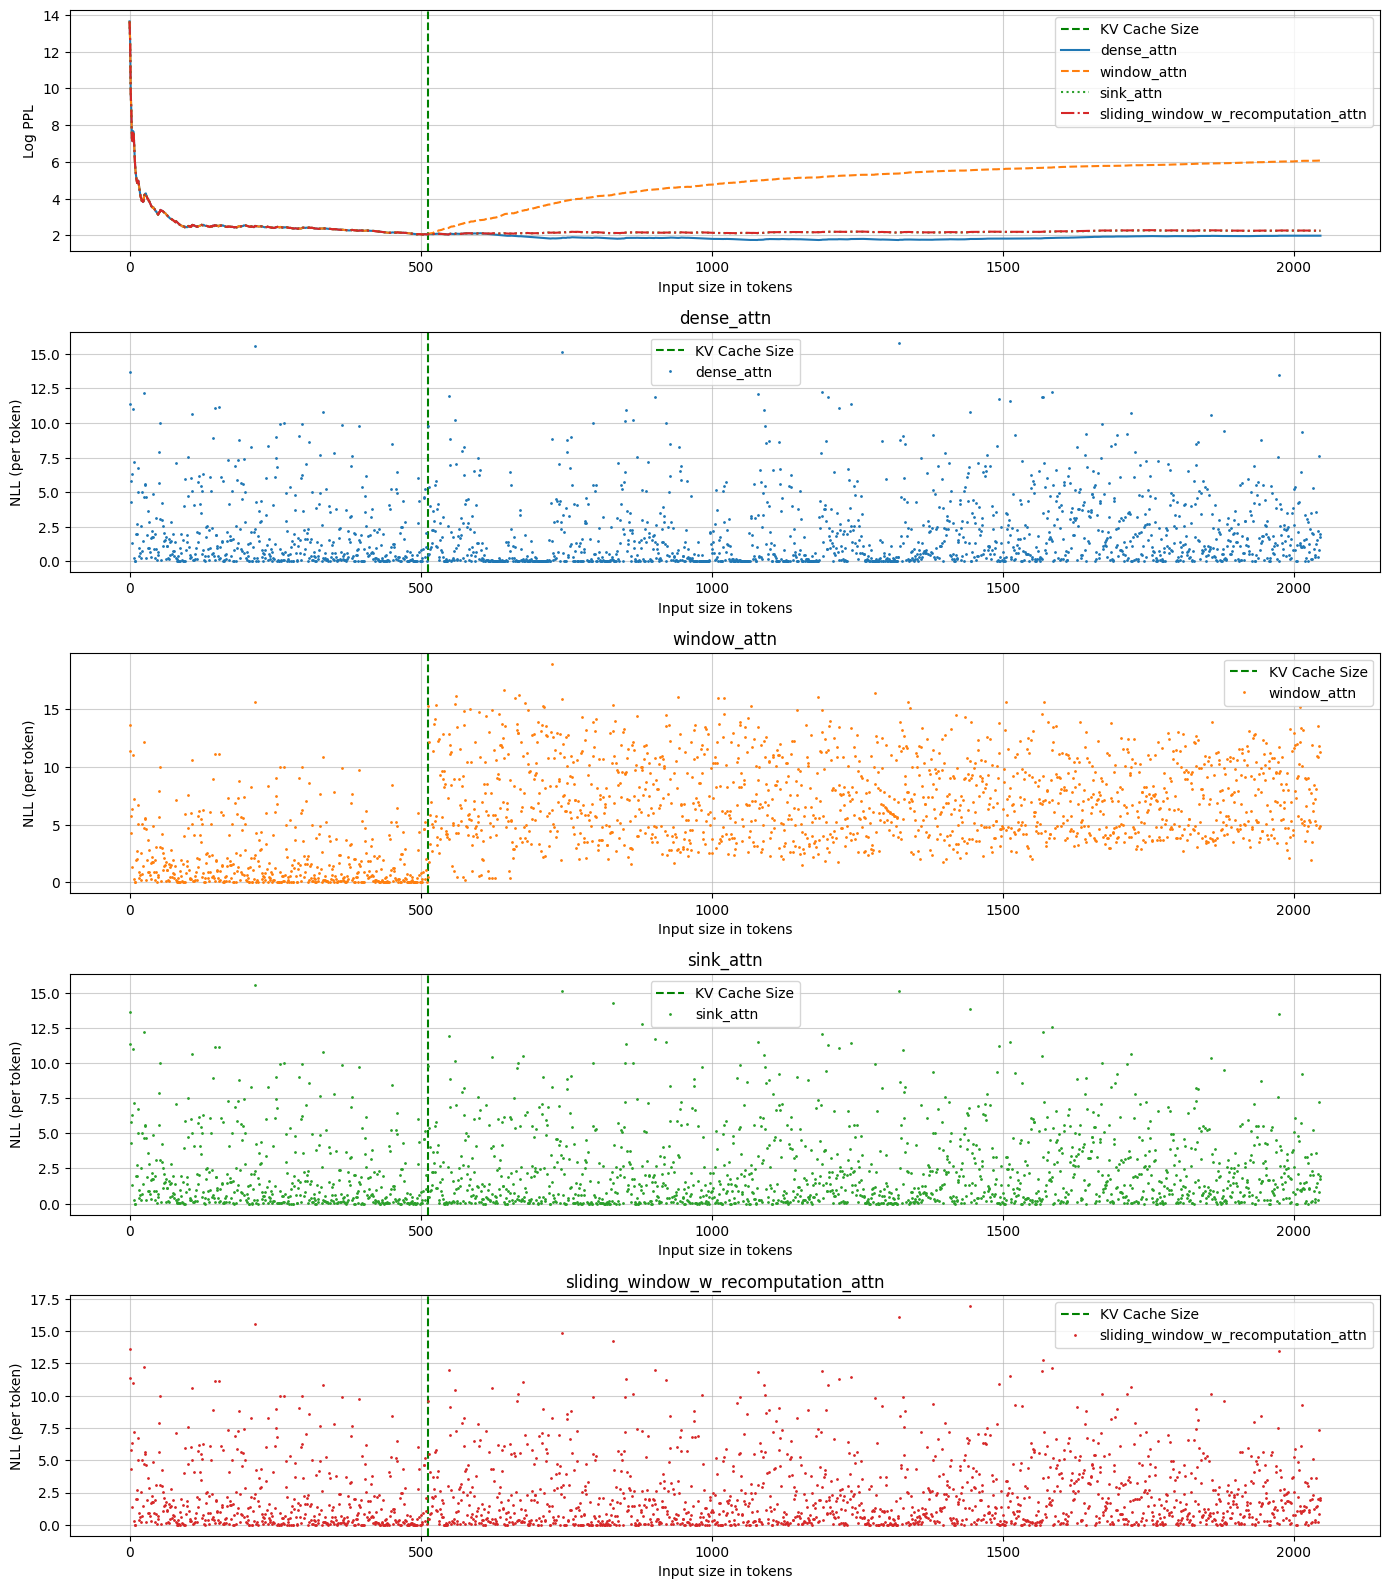

In [55]:
show_nlls(results_1a, kv_size_line=512, context_length_line=0)

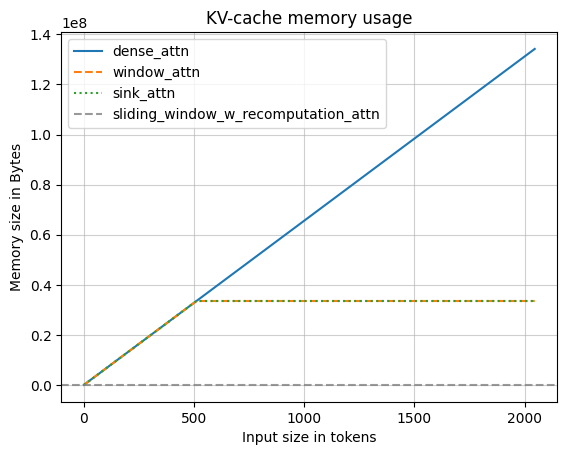

In [56]:
show_memory_usage(results_1a)

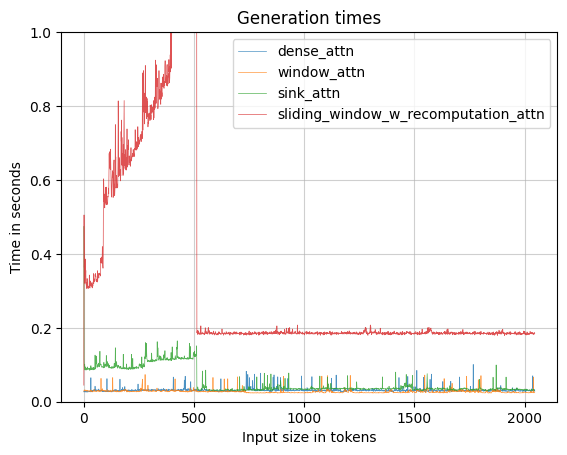

In [57]:
show_generation_times(results_1a)

In [159]:
show_statistics(results_1a)

KeyError: 'name'


#### Decoding sequences longer then model's context window

Llama3.2 has a context window of 131,072. Decoding such long sequences without production optimisations requires significant time. In this work, we focus on and explore the phenomenon of sink attention rather than measure streaming performance, hence we will demonstrate model performance when decoding sequences longer than the training context using GPT2. Crucially, this means we won't show sink attention because it is impossible to implement for GPT2, due to the use of absolute positional encodings added to token embeddings. 

GPT2 was trained on sequences of maximally 1024 tokens, hence we will test how attention implementation perform on sequences up to 2048 tokens.

In [126]:
experiment_1b_config = {
    "name": "experiment_1b",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": GPT2_MODEL_PATH,
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
    ],
}

#TODO Actually run this

In [ ]:
results_1b = run_attention_experiment(load_data(), experiment_1b_config)

#### Investigating the number of attention sinks

In [188]:
experiment_1c_config = {
    "name": "experiment_1c",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA_MODEL_PATH,
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
        {
            "name": "1-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 1,
        },
        {
            "name": "2-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 2,
        },
        {
            "name": "3-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 3,
        },
        {
            "name": "4-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "name": "10-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 10,
        },
    ],
}

In [ ]:
results_1c = run_attention_experiment(load_data(), experiment_1c_config)

In [ ]:
show_statistics(results_1c)

#### TODO Long decoding (try on a cluster)

In [ ]:
experiment_1d_config = {
    "name": "experiment_1d",
    "num_passes": 1,
    "chunk_len": 150_000,
    "model": LLAMA_MODEL_PATH,
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
    ],
}

In [ ]:
results_1d = run_attention_experiment(load_data(), experiment_1d_config)

In [ ]:
show_statistics(results_1d)

## Experiment 2

#TODO

Visualising the attention sinks.

2. The success of sink attention is based on two elements: 1) maintaining first n sink tokens, and 2) shifting positional encodings counting from 0 from the first sink token. 
	1. [ ] What if we do not shift the positional encodings but use n sink tokens?
		1. When the context length of a model is long, it should not hit the problem of overrunning the context length, and may be interesting to see the difference between the shifted PE and not.
	2. [ ] What if we only shift the positional encodings but do not use any sink tokens?
		1. Authors say that they experimented by changing the initial token id and that it does not matter for the sink effect, but retaining the initial token lowers PPL. Then, maybe it the position is the only thing that matters and is sufficient to change PEs.
		2. If shifting PEs doesn't work, then the sink location is not tied to the positional encoding. Then it is tied either to the token type (xiao et al. says no) or is invariant of that as well and is an outcome of the pre-training.
		3. Change the initial token value. 

### Using sink tokens without shifting positional encodings 

In [61]:
experiment_2a_config = {
    "name": "experiment_2a",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA_MODEL_PATH,
    "runs": [
        {
            "name": "window attention (no sink tokens, no positional shift)",
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "name": "sink attention without positional shift",
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "name": "sink attention with positional shift",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
    ],
}

In [62]:
results_2a = run_attention_experiment(load_data(), experiment_2a_config)

Running the following global configuration:('/Users/aszab/repos/models/Llama-3.2-1B', 1, 2048, 1)
Running the following run configuration:{'name': 'window attention (no sink tokens, no positional shift)', 'attn_impl': 'window_attn', 'kv_cache_size': 512, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 11.29, ppl: 80079.44: 100%|██████████| 2047/2047 [01:46<00:00, 19.21it/s]   


Running the following run configuration:{'name': 'sink attention without positional shift', 'attn_impl': 'window_attn', 'kv_cache_size': 512, 'sink_attn_tks': 4}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 13.54, ppl: 756176.25: 100%|██████████| 2047/2047 [01:38<00:00, 20.72it/s]  


Running the following run configuration:{'name': 'sink attention with positional shift', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 4}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 1.75, ppl: 5.74: 100%|██████████| 2047/2047 [01:56<00:00, 17.59it/s]       


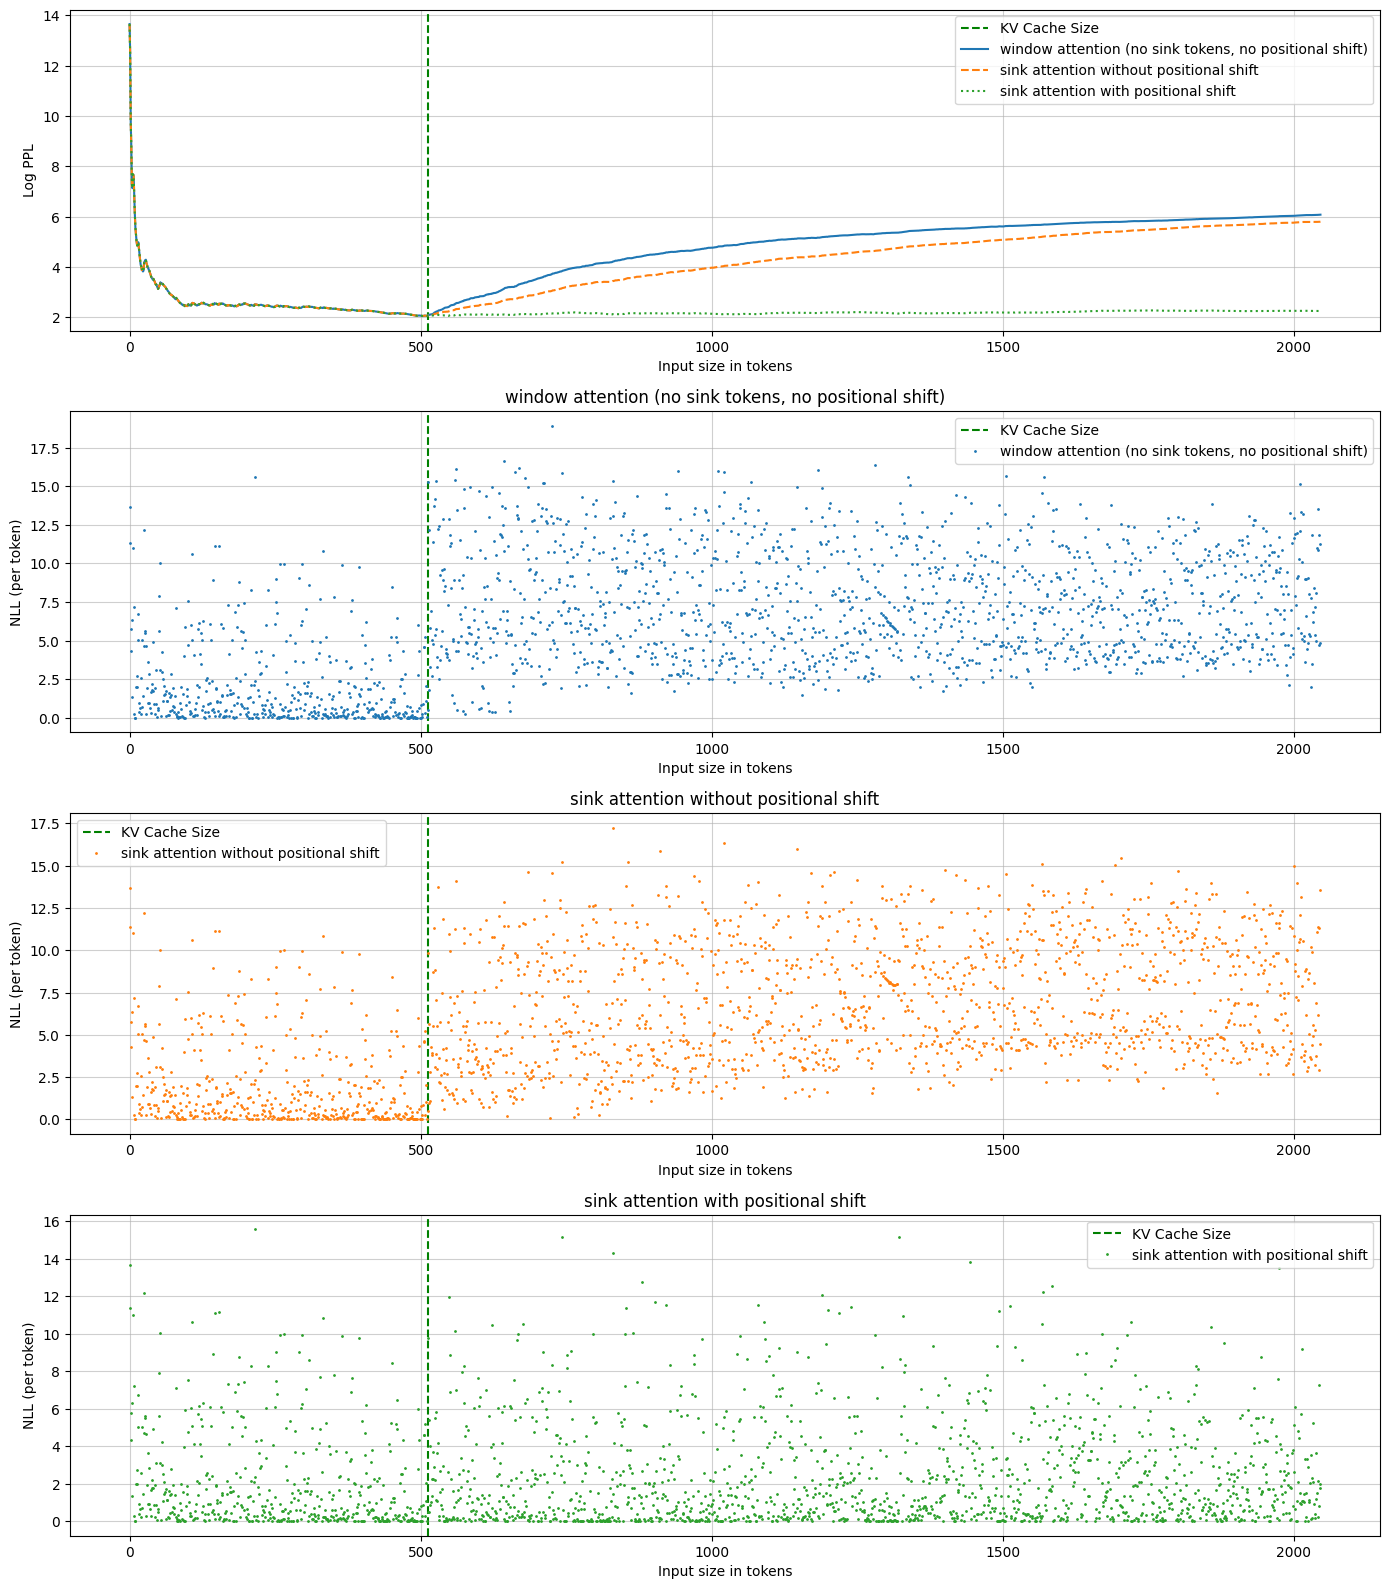

In [63]:
show_nlls(results_2a, kv_size_line=512, context_length_line=0)

KeyError: 'name'

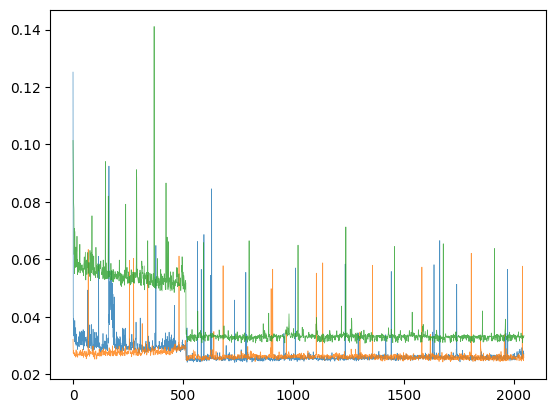

In [71]:
show_generation_times(results_2a)

In [ ]:
show_statistics(results_2a)

### Where the attention sinks appear? 

It's clear now that the attention sink phenomenon is taking place and the first token (which is the `<bos>` token) gets a significant amount of the attention score. However, it's important to understand what makes this token the attention sink. The following experiments will further investigate if:
- the model have learnt to use positional encodings and always designates the first token (most distant to the new context) as the attention sink,
- is it possible that the model have remembered to always use the beginning of sequence `<bos>` token as its attention sink.

#### Shift positional encodings without using sink tokens - window attention with positional encoding shift

In [72]:
experiment_2b_config = {
    "name": "experiment_2b",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA_MODEL_PATH,
    "runs": [
        {
            "name": "window attention (no sink tokens, no positional shift)",
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "name": "window attention with positional shift",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "name": "sink attention with positional shift",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
    ],
}

In [74]:
results_2b = run_attention_experiment(load_data(), experiment_2b_config)

Running the following global configuration:('experiment_2b', '/Users/aszab/repos/models/Llama-3.2-1B', 1, 2048, 1)
Running the following run configuration:{'name': 'window attention (no sink tokens, no positional shift)', 'attn_impl': 'window_attn', 'kv_cache_size': 512, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 11.29, ppl: 80079.44: 100%|██████████| 2047/2047 [01:46<00:00, 19.23it/s]   


Running the following run configuration:{'name': 'window attention with positional shift', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 16.03, ppl: 9187354.00: 100%|██████████| 2047/2047 [02:02<00:00, 16.69it/s] 


Running the following run configuration:{'name': 'sink attention with positional shift', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 4}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 1.75, ppl: 5.74: 100%|██████████| 2047/2047 [02:00<00:00, 17.03it/s]       


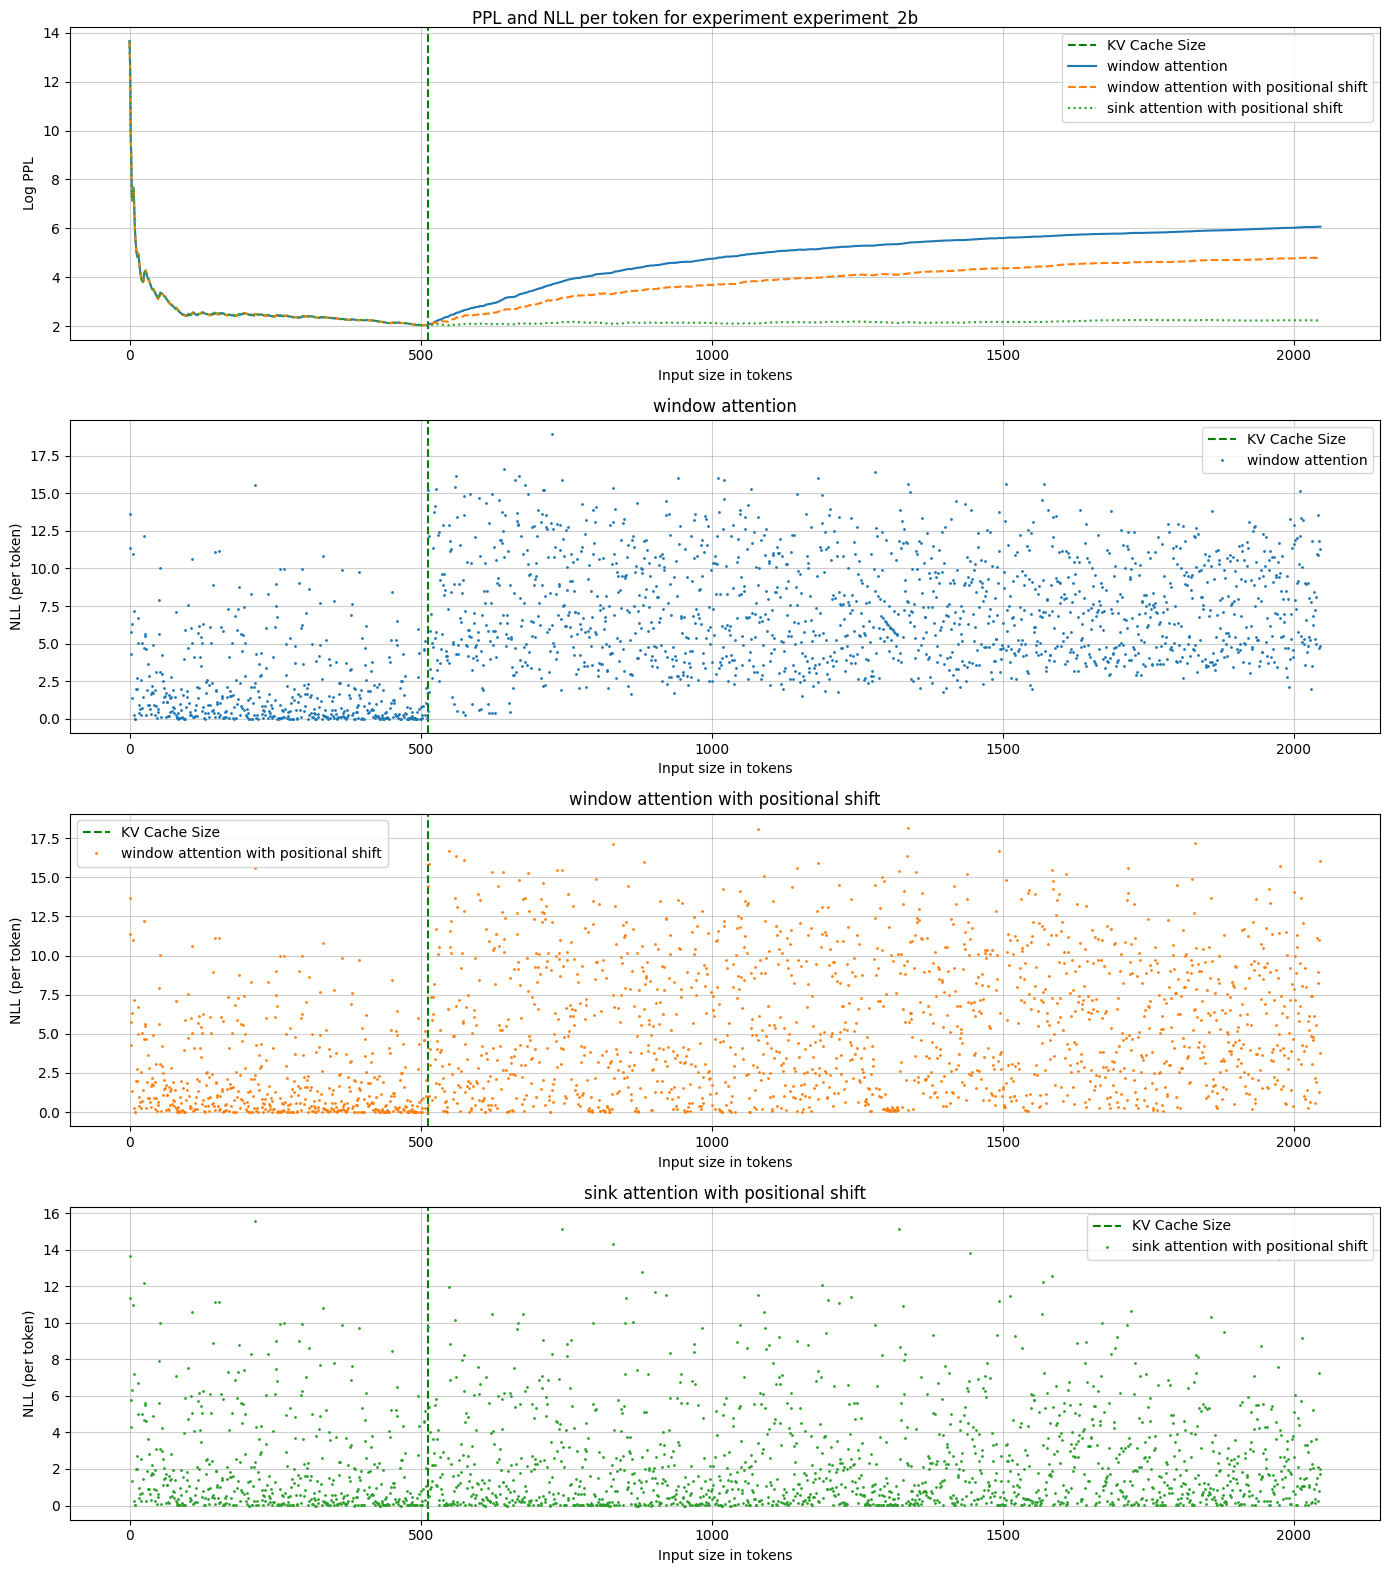

In [185]:
show_nlls(results_2b, kv_size_line=512, context_length_line=0)

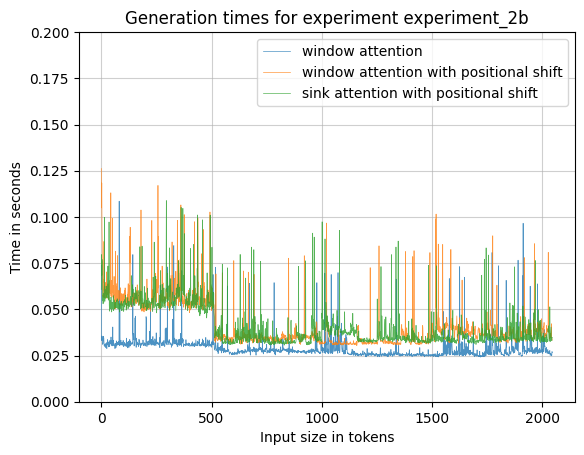

In [186]:
show_generation_times(results_2b, 0.2)

In [187]:
show_statistics(results_2b)

Name                        window attention window attention with positional shift sink attention with positional shift
Generation Time (mean ±std)       0.03 ±0.01                             0.04 ±0.01                           0.04 ±0.01
Max Memory Usage [MB]                   32.0                                   32.0                                 32.0
PPL (mean ±std)                434.62 ±54.47                          122.56 ±68.72                          9.44 ±14.29
PPL @ 10                            260.9045                               260.9045                             260.9045
PPL @ 256                            11.4795                                11.4795                              11.4795
PPL @ 512                             7.7431                                 7.7431                               7.7431
PPL @ 513                             7.9447                                 7.9317                               7.8607
PPL @ 768                       



#### Is `<bos>` designated to become an attention sink? - sink attention with removed <bos> token

In [200]:
experiment_2c_config = {
    "name": "experiment_2c",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA_MODEL_PATH,
    "runs": [
        {
            "name": "1-sink attention with removed bos token",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 1,
            "remove_bos_token": True,
        },
        {
            "name": "1-sink attention",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 1,
        },
    ],
}

In [201]:
results_2c = run_attention_experiment(load_data(), experiment_2c_config)

Running the following global configuration:('experiment_2c', '/Users/aszab/repos/models/Llama-3.2-1B', 1, 2048, 1)
Running the following run configuration:{'name': '1-sink attention with removed bos token', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 1, 'remove_bos_token': True}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.01, ppl: 1.01: 100%|██████████| 2048/2048 [02:09<00:00, 15.79it/s]        


Running the following run configuration:{'name': '1-sink attention', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 1}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.19, ppl: 1.21: 100%|██████████| 2048/2048 [01:59<00:00, 17.10it/s]        


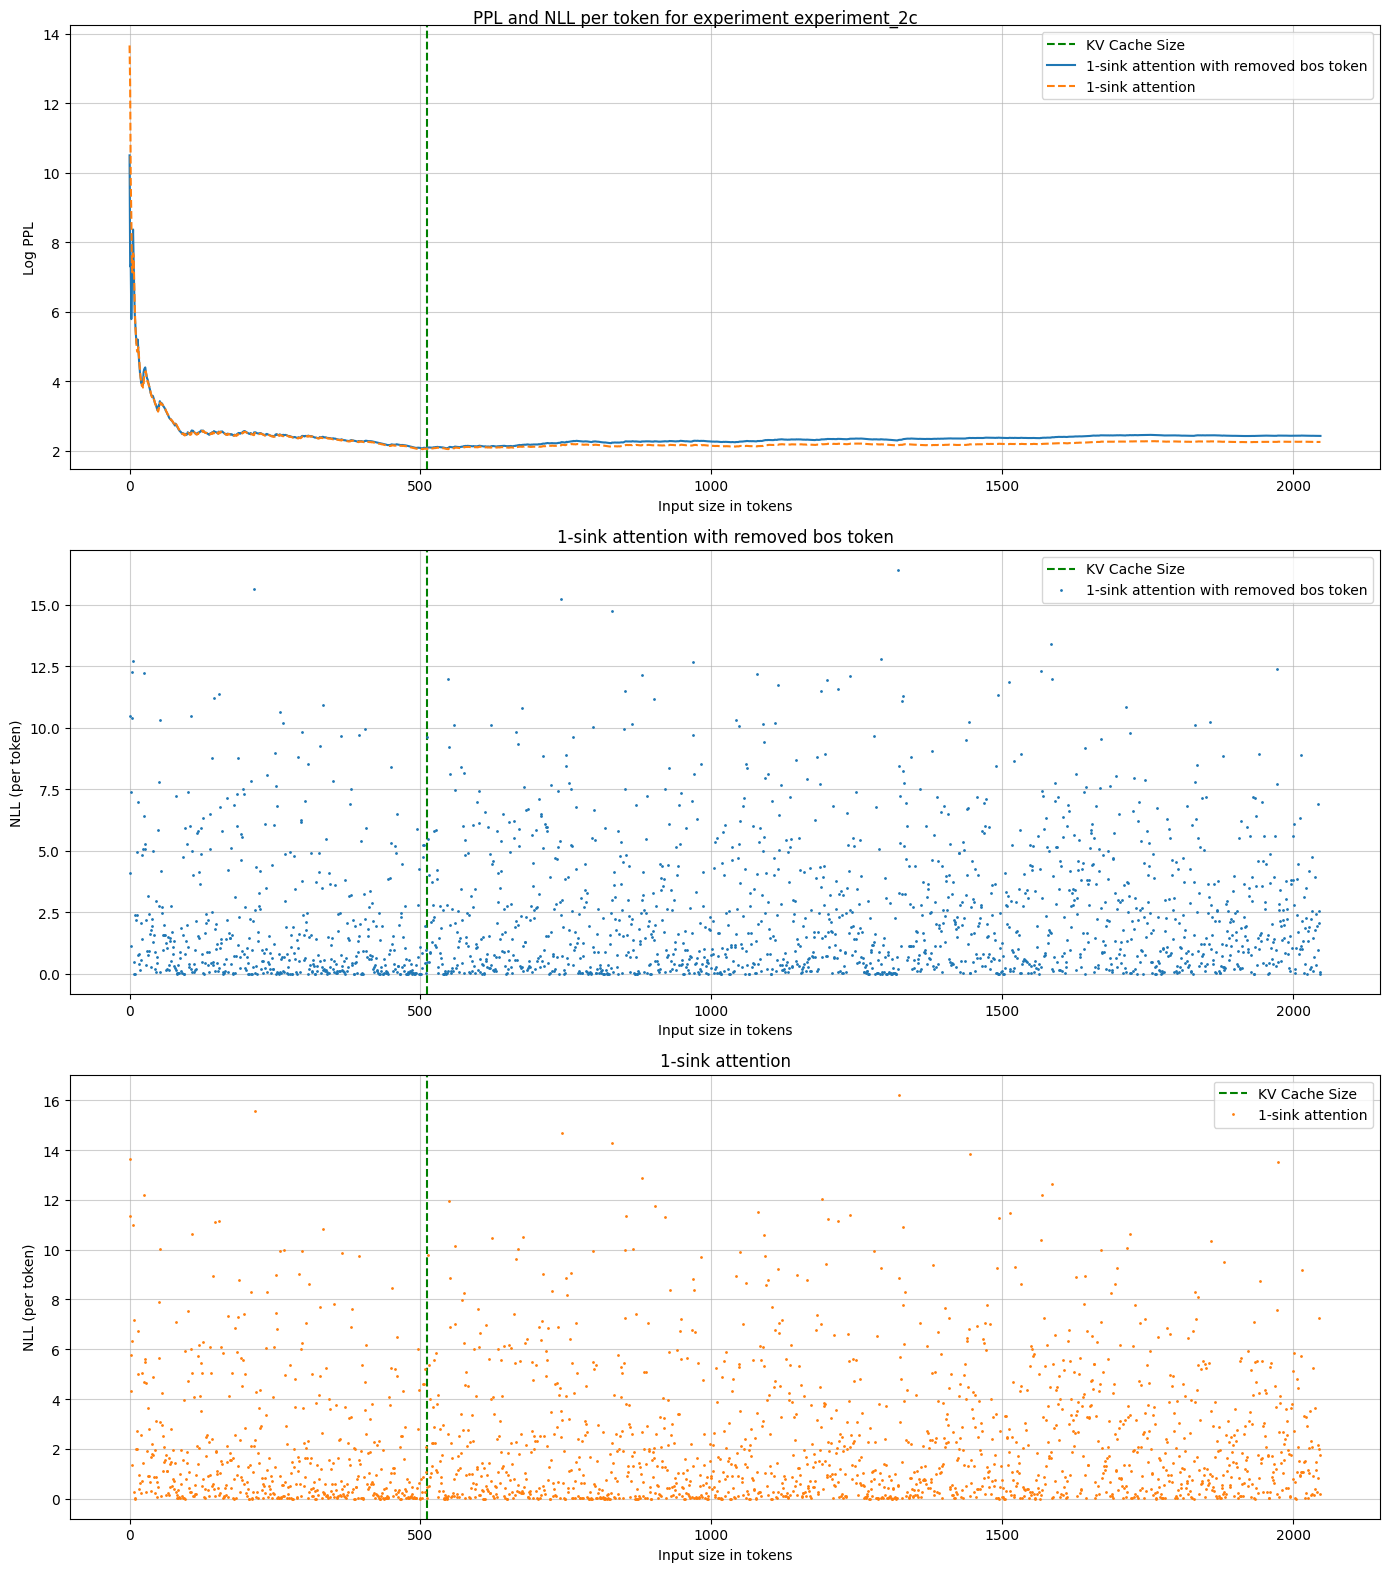

In [203]:
show_nlls(results_2c, kv_size_line=512, context_length_line=0)

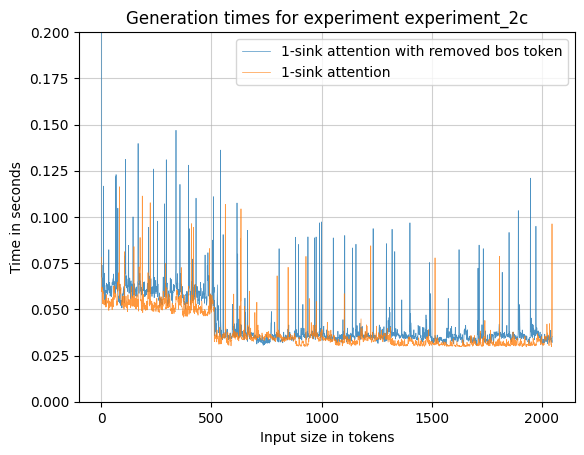

In [204]:
show_generation_times(results_2c, 0.2)

In [205]:
show_statistics(results_2c)

Name                        1-sink attention with removed bos token 1-sink attention
Generation Time (mean ±std)                              0.04 ±0.02       0.04 ±0.01
Max Memory Usage [MB]                                          32.0             32.0
PPL (mean ±std)                                        11.29 ±15.18      9.49 ±14.34
PPL @ 10                                                   265.6746         260.9045
PPL @ 256                                                   11.5161          11.4795
PPL @ 512                                                    8.0477           7.7431
PPL @ 513                                                     8.101           7.8606
PPL @ 768                                                    9.8079           8.9042
PPL @ 1024                                                   9.5268           8.3722
PPL @ 1536                                                  10.6587           8.9557


## Experiment 3

#TODO

Since PEs do not influence the sink location and they are also invariant of the token ids, they must occur as a result of pre-training. Now, there are papers, that explain their phenomenon and show that attention sinks are closely related to massive activations. In fact, sink locations are dictated not just by the first token position in training but also other tokens that bear low semantic meaning. This series of experiments investigates it. 

- [ ] Show the curves across decoder layers and attn heads for a test sequence

Since some publications claim that these attentions sink tokens are essentially repurposed tokens to serve as (implicit) attention biases,
1. [ ] how to identify them, and
2. [ ] does their presence or the lack of their presence influence the PPL/reasoning benchmarks?
It has been shown that adding a learnable key-value explicitly to each attention head can remove the massive activations and (partially) resolve the attention sink phenomenon. Since this study avoids training or re-training models, 
1. [ ] we can see if synthetically injecting tokens with low-semantic value, can help the model with better balancing of the attention score and potentially increase its reasoning capability (using some benchmarks) through the use of these tokens as some sort of registers.

### Visualising the attention sinks

In [206]:
def get_attn_map(
    attn: tuple[torch.Tensor],
    layer_num: int,
    head_num: int,
    remove_first_token: bool = False,
) -> np.ndarray:
    """
    Retrieves the attention map for a specified layer and head from the model's attention outputs.

    Args:
        attn (tuple[torch.Tensor]): A tuple of attention tensors from the model's output.attentions.
        layer_num (int): The index of the layer from which to retrieve the attention map.
                         If -1, the attention maps across all layers are averaged.
        head_num (int): The index of the head from which to retrieve the attention map.
                        If -1, the attention maps across all heads are averaged.

    Returns:
        np.ndarray: The attention map for the specified layer and head.
    """
    attn = torch.stack(attn).cpu().detach().numpy()
    if layer_num == -1:
        attn = attn.mean(axis=0, keepdims=True)
        layer_num = 0

    if head_num == -1:
        attn = attn.mean(axis=2, keepdims=True)
        head_num = 0

    attn_map = attn[layer_num, 0, head_num, :, :]
    if remove_first_token:
        attn_map = attn_map[1:, 1:]

    return attn_map

In [207]:
def show_attn(
    attn_map: np.ndarray, token_labels: list[str], log_scale: bool = False
) -> None:
    """
    Visualizes an attention map with token labels.

    Parameters:
        attn_map (np.ndarray): The attention map to visualize. It is expected to be a 2D array.
        token_labels (list[str]): A list of token labels corresponding to the attention map.
        log_scale (bool, optional): If True, applies a logarithmic scale to the attention map values. Defaults to False.

    Returns:
        None
    """
    _, ax = plt.subplots(figsize=(8, 8))

    # mask for plotting the bad color for padding tokens (upper triangular part)
    attn_map = np.ma.masked_where(attn_map == 0, attn_map)

    cmap = plt.cm.coolwarm
    cmap.set_bad(color="grey")
    ax.matshow(np.log(attn_map) if log_scale else attn_map, cmap=cmap)

    ax.xaxis.set_label_position("bottom")  # Move x-axis label to the bottom
    ax.xaxis.tick_bottom()  # Ensure ticks are on the bottom
    _ = ax.set_xticks(
        range(len(token_labels)),
        token_labels,
        fontsize=9,
        rotation=90,
    )
    _ = ax.set_yticks(
        range(len(token_labels)),
        token_labels,
        fontsize=9,
    )
    ax.set_ylabel("Query token", fontsize=12)
    ax.set_xlabel("Key token", fontsize=12)

In [208]:
llama3_model, llama3_tokenizer = load_model_tokenizer(
    LLAMA_MODEL_PATH,
    attn_implementation="eager",
    output_attn=True,
)

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [209]:
NUM_LAYERS = llama3_model.config.num_hidden_layers
NUM_HEADS = llama3_model.config.num_attention_heads

In [210]:
prompt = "Hello, my dog is cute and playful, although my cat isn't."
inputs = llama3_tokenizer(
    prompt,
    return_tensors="pt",
).to(device)

with torch.no_grad():
    outputs = llama3_model(
        **inputs,
    )

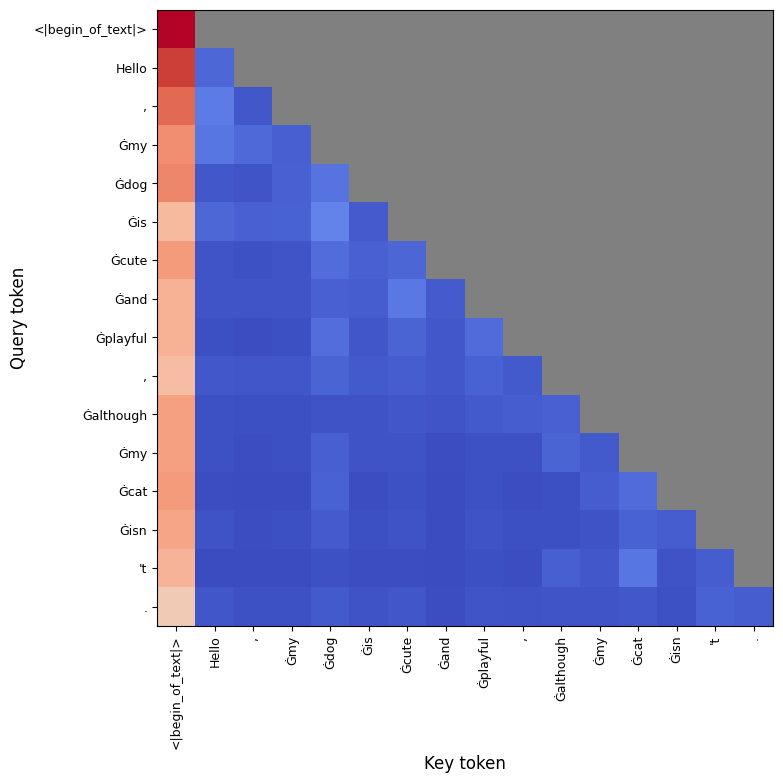

In [211]:
show_attn(
    get_attn_map(
        outputs.attentions,
        3,
        -1,
    ),
    llama3_tokenizer.convert_ids_to_tokens(
        inputs["input_ids"].cpu().detach().numpy()[0]
    ),
)

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_27978/2819793652.py:22: RuntimeWarning: divide by zero encountered in log
  ax.matshow(np.log(attn_map) if log_scale else attn_map, cmap=cmap)


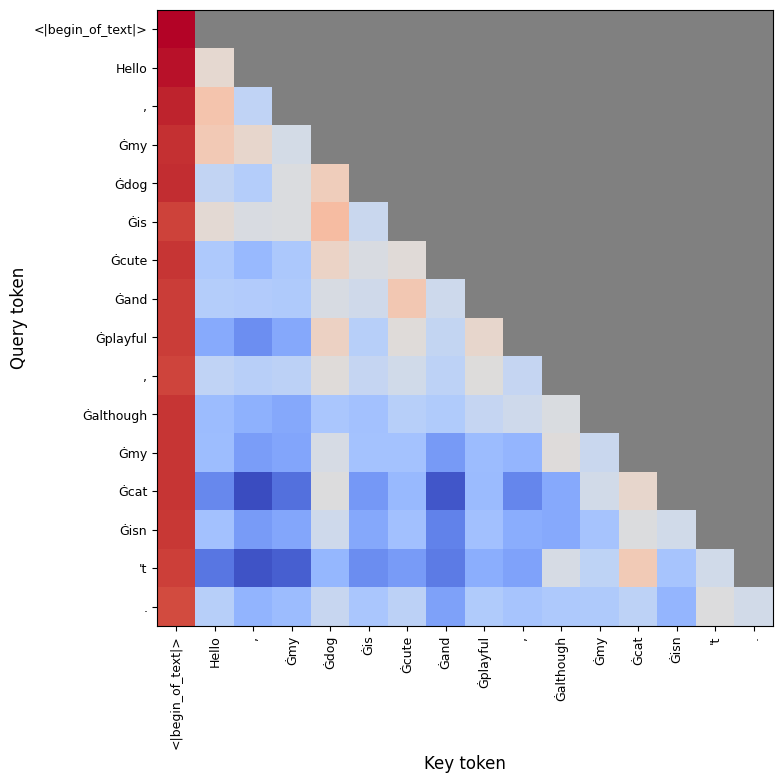

In [212]:
show_attn(
    get_attn_map(
        outputs.attentions,
        3,
        -1,
    ),
    llama3_tokenizer.convert_ids_to_tokens(
        inputs["input_ids"].cpu().detach().numpy()[0]
    ),
    log_scale=True,
)

In [213]:
def show_attn_layers(attn_map_lst: list[np.ndarray], log_scale: bool = False) -> None:
    """
    Visualizes attention maps for each layer in a grid layout.

    Parameters:
        attn_map_lst (list[np.ndarray]): A list of attention maps, where each attention map is a 2D numpy array.
        log_scale (bool): If True, applies a logarithmic scale to the attention maps for visualization. Default is False.

    Returns:
        None
    """
    fn = np.log if log_scale else lambda x: x

    n_cols = 4
    n_rows = len(attn_map_lst) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 10))

    for i, attn_map in enumerate(attn_map_lst):
        # mask for plotting the bad color for padding tokens (upper triangular part)
        attn_map = np.ma.masked_where(attn_map == 0, attn_map)

        cmap = plt.cm.coolwarm
        cmap.set_bad(color="grey")
        axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)

        axs[i // n_cols][i % n_cols].xaxis.set_label_position(
            "bottom"
        )  # Move x-axis label to the bottom
        axs[i // n_cols][
            i % n_cols
        ].xaxis.tick_bottom()  # Ensure ticks are on the bottom

        axs[i // n_cols][i % n_cols].set_title(f"Layer {i}")
        axs[i // n_cols][i % n_cols].set_ylabel("Query token", fontsize=10)
        axs[i // n_cols][i % n_cols].set_xlabel("Key token", fontsize=10)
        fig.tight_layout()

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_27978/2761506107.py:24: RuntimeWarning: divide by zero encountered in log
  axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)


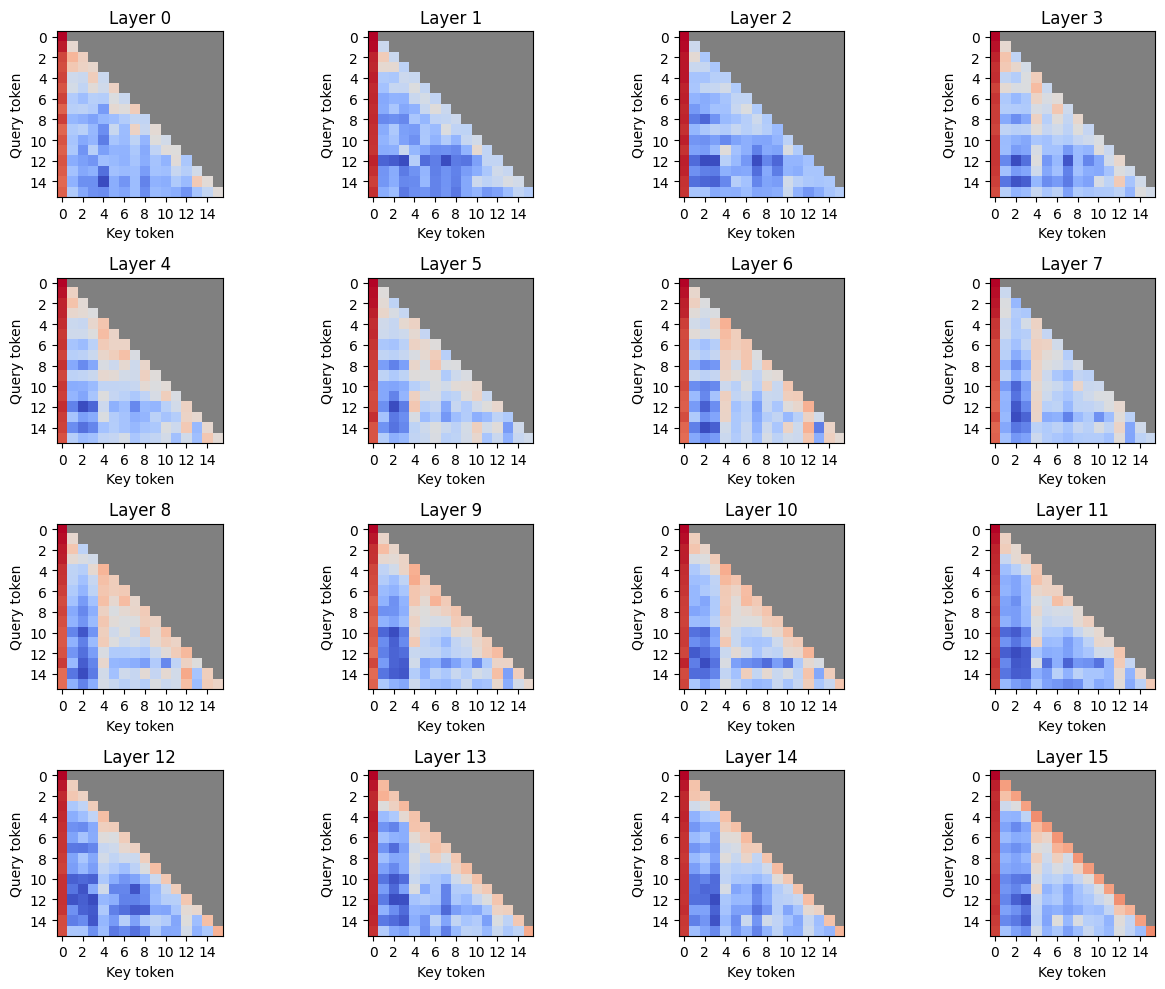

In [214]:
show_attn_layers(
    [get_attn_map(outputs.attentions, i, -1) for i in range(16)], log_scale=True
)

### How much attention is "wasted" in a sink?

Text(0, 0.5, 'Propotion of attention given to the first token')

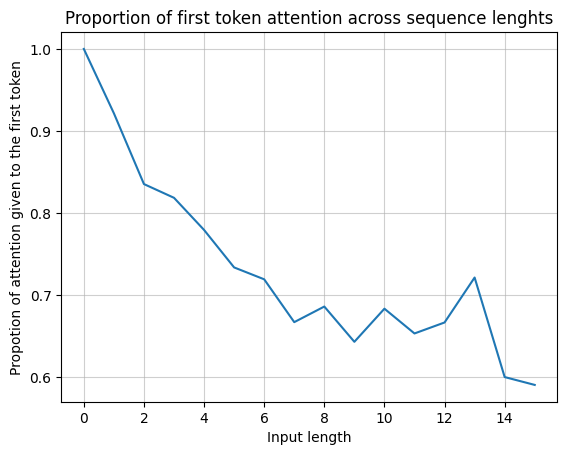

In [215]:
attn_map = get_attn_map(outputs.attentions, -1, -1)
plt.plot(range(attn_map.shape[1]), attn_map[:, 0])
plt.grid(zorder=1, alpha=0.6)
plt.title("Proportion of first token attention across sequence lenghts")
plt.xlabel("Input length")
plt.ylabel("Propotion of attention given to the first token")

In [224]:
encodings = llama3_tokenizer(load_data(), return_tensors="pt").to(device)

num_samples = 100
sample_length = 1024

assert num_samples * sample_length <= encodings.input_ids.size(1)

attention_outputs = [
    torch.zeros(1, NUM_HEADS, sample_length, sample_length).to(device)
    for _ in range(NUM_LAYERS)
]

for idx in tqdm(range(num_samples)):
    with torch.no_grad():
        outputs = llama3_model(
            encodings.input_ids[:, idx * sample_length : (idx + 1) * sample_length],
        )

    # accumulate mean
    for block_id in range(NUM_LAYERS):
        attention_outputs[block_id] += outputs.attentions[block_id] / num_samples

    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


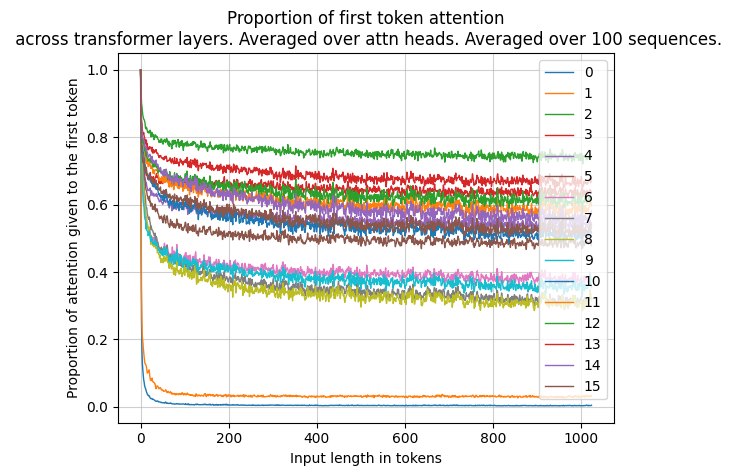

In [227]:
for layer_id in range(NUM_LAYERS):
    attn_map = get_attn_map(attention_outputs, layer_id, -1)
    plt.plot(range(attn_map.shape[1]), attn_map[:, 0], linewidth=1, label=layer_id)
plt.title(
    "Proportion of first token attention\n across transformer layers. Averaged over attn heads. Averaged over 100 sequences."
)
plt.grid(zorder=1, alpha=0.6)
plt.xlabel("Input length in tokens")
plt.ylabel("Proportion of attention given to the first token")
plt.legend()

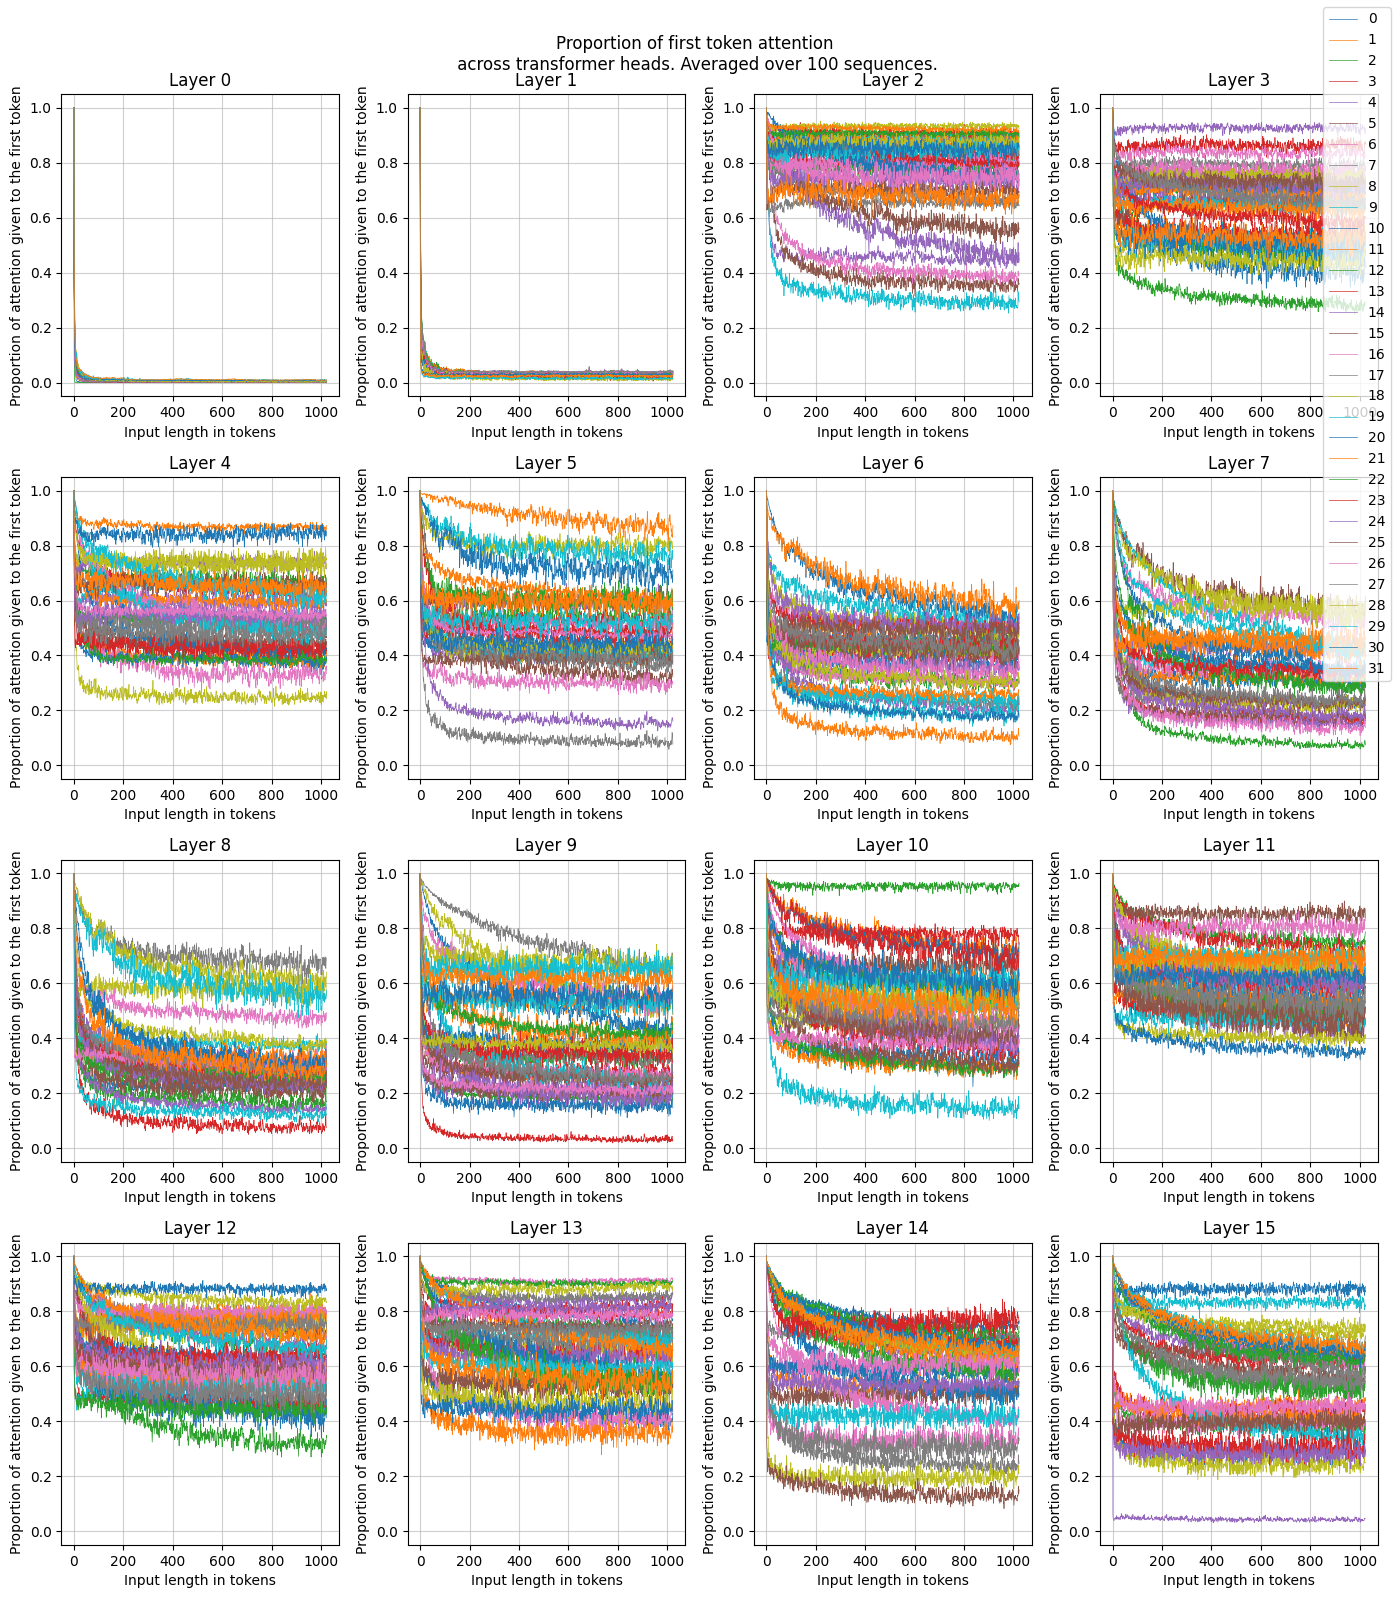

In [232]:
n_cols = 4
n_rows = NUM_LAYERS // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))


for layer_id in range(NUM_LAYERS):
    for head_id in range(NUM_HEADS):
        attn_map = get_attn_map(attention_outputs, layer_id, head_id)
        ax[layer_id // n_cols][layer_id % n_cols].plot(
            range(attn_map.shape[1]), attn_map[:, 0], linewidth=0.5, label=head_id
        )
    ax[layer_id // n_cols][layer_id % n_cols].set_title(f"Layer {layer_id}")
    ax[layer_id // n_cols][layer_id % n_cols].set_xlabel("Input length in tokens")
    ax[layer_id // n_cols][layer_id % n_cols].set_ylabel(
        "Proportion of attention given to the first token"
    )
    ax[layer_id // n_cols][layer_id % n_cols].set_ylim(-0.05, 1.05)
    ax[layer_id // n_cols][layer_id % n_cols].grid(zorder=1, alpha=0.6)


fig.suptitle(
    "Proportion of first token attention\n across transformer heads. Averaged over 100 sequences."
)
fig.tight_layout()
fig.legend(labels=list(range(NUM_HEADS)), loc="upper right")